# Chutes and Ladders : Markov Processes in Games

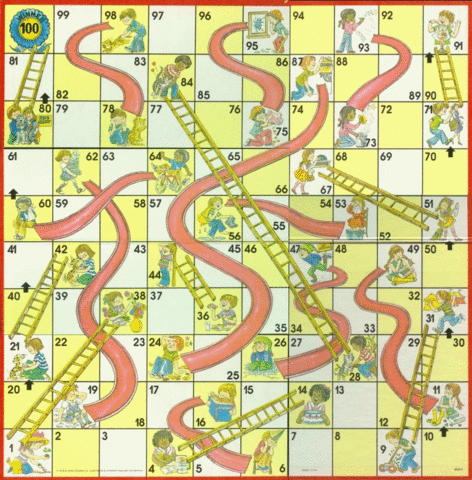

(image from [uncyclopedia](http://uncyclopedia.wikia.com/wiki/Chutes_and_Ladders))

Chutes and Ladders may be known as a simple game from childhood.  It has a long history, originating in India as [Snakes and Ladders](https://en.wikipedia.org/wiki/Snakes_and_Ladders).  The philosophical nature of the game has been extensively studied in academic circles.  It is also an example of Markov process, one that we can apply our knowledge to and study.

The discussion here is based on a [blog post](https://jakevdp.github.io/blog/2017/12/18/simulating-chutes-and-ladders/) which includes the analysis of other aspects of the game, some nice images, and animations.

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

# Create a random generator for use
rng = np.random.default_rng()

## A Simpler Game

Before getting into Chutes and Ladders, let us consider an even simpler game.

Any number of players take turns rolling a $d$ sided die (a die that produces values from 1 through $d$).  They add the value of the roll of the die to their current total (having started from zero).  The first player to *exactly* reach a total, $N$, is the winner.  More explicitly each player in the game follows the steps
1. Start with total = 0.
2. In turn, roll a $d$ sided die.
3. Add the value of the roll to your total provided the new total is less than or equal to $N$.  If the value would be larger than $N$, then the roll is ignored and the total remains unchanged.
4. If the total is equal to $N$ you win the game.  If not, go back to step 2.

Here we will study the rolls of a *single player*.  We will determine some basic properties of the game.

The simplest way to approach this is use brute force: simulate games!  We do that below.

In [2]:
def simulate_dice_game (rng, die=6, total=100) :
    """
    Simulate a game of rolling the given die to find the number of rolls
    required to reach the given total.
    Returned is the number of turns required.
    """
    val = 0
    rolls = 0
    while val < total :
        rolls += 1
        d = rng.integers(1, high=die, endpoint=True)
        if val + d <= total :
            val += d
    return rolls

print("Required rolls:", simulate_dice_game(rng))

Required rolls: 29


This is nice, we can now simulate a game.  To explore the properties of it, we need to perform many realizations.  Let's write a function for that too.

In [3]:
def simulate_dice_games_MC (rng, Nmc, die=6, total=100) :
    rolls = np.zeros(Nmc, dtype=int)
    for j in range(Nmc) :
        rolls[j] = simulate_dice_game(rng, die, total)
    return rolls

This is a rather inefficient way of studying this problem. If it were the only approach, we would live with that.  Using realizations is a standard tool for simulations in physics, but besides being inefficient, it has some other draw backs, as we will see.

Regardless, to quantify how slow this is we can use a *cell magic* that the notebook provides, `%%timeit`.  This will time the code run in the cell.  We could have (maybe even should have) been using this throughout the semester to quantify what we meant when we said certain approaches were slower than others.  Here is an example of how to use it.

This will take a noticeable time to run since, well, it is slow.  Further, it runs the cell multiple times to get better, more accurate timing information.

In [4]:
%%timeit
simulate_dice_games_MC(rng, 100000)

12.6 s ± 1.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


So we see that it takes some number of seconds per run (exactly how many depends on your computer, in the end though, running this cell alone takes more time than all the rest of the cells in the notebook combined).  That is not horrible, but it does tell us that if we wanted to do more realizations it is going to take more and more time.  We would not want to run this with, say, 100 times and many realizations and sit around waiting for it.

One important fact is that it does not store any information about the results of the run, they are thrown away.  Even if we had assigned the results to a variable, that variable would not have been set.  Thus we will run it one more time to get an array of results for further analysis.

In [5]:
rolls = simulate_dice_games_MC(rng, 100000)

We are now going to ask some questions about the distribution of the number of rolls in the games we just simulated.  The easiest way to answer these questions will be sort the number of rolls.  This can be done in-place, meaning the original array is changed.

In [6]:
rolls.sort()

#### Minimum Rolls

Given a $d$ sided die and a total of $N$ that we want to reach, what is the minimum number of rolls that would be required? How would we construct this?  What is the best we could hope for?  We can answer this before looking at the set of realizations we just generated.

Here we can just think about the optimal rolls.  The best we could hope for is always rolling a $d$.  If $N$ is a multiple of $d$ then the minimum number of rolls would just be $N/d$.  If $N$ is not a multiple of $d$, then we will need one more roll to get exactly to $N$.  In other words, using the `floor` function, represented mathematically by $\lfloor\cdot\rfloor$, we can write this as
$$
n_{\mathrm{min}} = \begin{cases} N/d, & N\mod d=0, \\
\lfloor N/d \rfloor + 1, & \mbox{otherwise}. \end{cases}
$$

For the example above this would give
$$
n_{\mathrm{min}} = \lfloor 100/6 \rfloor + 1 = 17.
$$

Did our simulation find that actual minimum? Should it have?
It probably did not.  It would be very, very unlikely to get the optimal set of rolls.  We should not expect our simulation to get this correct.  This is a standard problem with doing simulations, things in the "tail" of the distribution are not well probed.  We would need far more than 100,000 realizations to believe what is going on in the "tails".

We will see more of this below. For now, let us compare the simulation to expectation.

In [7]:
# Since we have sorted rolls, we know the minimum is the first entry.
print(f"""
Expected minimum rolls : 17
Actual minimum rolls   : {rolls[0]}
""")


Expected minimum rolls : 17
Actual minimum rolls   : 20



#### Maximum Rolls

The maximum number of rolls is easy to determine; just assume we are very unlucky.  Suppose we roll until we reach a value $N-1$, and then never roll a one.  The game will never end.  Thus, the maximum number of rolls is infinite.  Of course the probability of this is also extremely small.  The game will, in fact, always end in practice.  But in principle it could never end.  Our simulation will never find that!

Thus the maximum number of rolls really is not interesting.  A better question would be to ask for the number of rolls required to have a certain probability of winning.  We will ask, what is the number of rolls required to have a 99% chance of winning.  We can extract this from our simulations.

In [8]:
# Get the index where the 99% probability would be.
# We round by hand (you could use np.round()).
# The result needs to be an integer so we can use it as an index.
ind_99 = int(0.99*len(rolls)+0.5)
print("99% win rolls :", rolls[ind_99])

99% win rolls : 54


#### Median

We can also determine the number of rolls required such that we have a 50% chance of having won the game.  This is nothing more than the median of distribution which is easy to determine from the sorted simulation.  I do not know of a simple argument to get this, so we just look at the result from the simulations.

In [9]:
print("Median number of rolls :", rolls[len(rolls)//2])

Median number of rolls : 32


#### Probability Distribution

Finally, we can look at the full probability distribution.  Here we show lines for the values quoted above.  Notice that the minimum value and the 99% value are in the "tails" of the distribution.  There are very few realizations (or probably none in the case of the expected minimum).  This is a limitation of realizations.  We must be careful about trusting them too much.  They tell us little of what is happening in the low probability regions.  We would need many, many more realizations to say anything about the actual minimum.  If we had not been able to calculate it in another way, how much should we have trusted the realizations?  Without knowing the true probability distribution, we do not know.

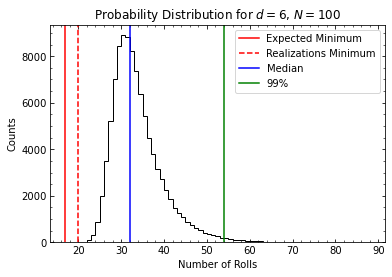

In [10]:
# Choose integer bins going from the minimum allowed to just past the maximum found.
bins = np.arange(17, rolls.max()+2, 1)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(rolls, bins=bins, histtype="step", align="mid", color='k')
ax.axvline(17, color='r', label='Expected Minimum')
ax.axvline(rolls[0], color='r', ls='--', label='Realizations Minimum')
ax.axvline(rolls[len(rolls)//2], color='b', label='Median')
ax.axvline(rolls[ind_99], color='g', label='99%')
ax.legend()
ax.set_xlabel('Number of Rolls')
ax.set_ylabel('Counts')
ax.set_title('Probability Distribution for $d=6$, $N=100$');

### Markov Process

Fortunately, the game described here can be analyzed in another, more elegant, manner.  We do not need to rely on realizations by recognizing that the game described here is a Markov process.  With this, we can perform a more efficient, more exact numerical analysis.

As we saw in PreLab 11, we can study this by considering the transition matrix, $\mathsf{P}$, where
$$ \mathsf{P} = \begin{pmatrix}
P_{0,0} & P_{1,0} & P_{2,0} & \cdots & P_{N,0} \\
P_{0,1} & P_{1,1} & P_{2,1} & \cdots & P_{N,1} \\
P_{0,2} & P_{1,2} & P_{2,2} & \cdots & P_{N,2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
P_{0,N} & P_{1,N} & P_{2,N} & \cdots & P_{N,N} 
\end{pmatrix}. $$
Here $P_{i,j}$ represents the probability of transitioning from state $i$ to state $j$.  For the game we have described above, this is the probability of transitioning from total $i$ to total $j$ given a roll of a die.  We can immediately write down the transition probabilities for this game.  First, since we always add the result of a roll (the total always increases) it must be the case the $P_{i,j}=0$ for $i>j$: we can never transition to a smaller total.  In fact, we can only transition to states within $d$ of our current state, thus $P_{i,j} = 1/d$ for $i+1\le j \le i+d$. Finally, $P_{i,i}=0$ except when our total is near $N$.  In that case there are some rolls for which the total does not change.  In these cases $P_{i,i}$ is the probability of getting a roll that would put our total over $N$. In particular, it must be the case that $P_{N,N}=1$.  In fact, for all $N-d < i \le N$ we will have $P_{i,i}\ne 0$. Lastly, remember that the sums of the columns of a transition matrix must be one ($\sum_j P_{i,j}=1$). That is, in each step of the game you are guaranteed to be in some state.

Though we are going to be interested in the case $N=100$ and $d=6$, we will write a function for creating the transition matrix that works for any $N$ and $d$.  (Actually, we will assume $N>d$.  The function below may not work for $N<d$.)  To test this it is convenient to have a much smaller case that we can more easily examine.  As an example, here is the transition matrix for $N=6$ and $d=4$.  (Note that it is a $7\times 7$ matrix and that I have pulled out a factor of $1/4$ to more easily show the structure of the matrix.)
$$ \mathsf{P} = \frac{1}{4} \begin{pmatrix}
    0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & 1 & 0 & 0 & 0 & 0 & 0 \\
    1 & 1 & 1 & 1 & 0 & 0 & 0 \\
    1 & 1 & 1 & 1 & 2 & 0 & 0 \\
    0 & 1 & 1 & 1 & 1 & 3 & 0 \\
    0 & 0 & 1 & 1 & 1 & 1 & 4
   \end{pmatrix}. $$
   
The easiest way to construct the transition matrix is to use a double loop.  In this case that probably would not be so bad, but we can do better.  Here we use a loop and `np.eye` to fill in the appropriate elements of the matrix.  We then use another loop to correct the entries at the end of the matrix.

In [11]:
def make_transition_matrix (N, d=6) :
    P = np.zeros((N+1,N+1))
    # Here we use np.eye() to fill in the appropriate off diagonal elements.
    for j in range(1, d+1) :
        P += np.eye(N+1, k=-j)
    # Next we fix the cases where we would go off the end. Here we fill in the diagonal
    # entries of the final d columns to account for rolls that would move us past the
    # desired total.  We are also a bit more general than required.  By using '+=' instead
    # of just '=' we are allowing for changes to the rules that make the probability of
    # staying in the current state non-zero.
    for c in range(-d, 0) :
        P[c,c] += d - P[:,c].sum()
    # Finally, renormalize so that total probabilities in each column are one.
    return P / d

As always we should test the result.  We will use the case from above (despite it being so large, a smaller one would also be fine).

In [12]:
# Print so we can see it
Ptest = make_transition_matrix(6, 4)
print("Transition matrix for N=6, d=4:\n", Ptest)
# and assert so we can really be sure they are the same.
assert(np.allclose(Ptest,
                  1/4 * np.array([[0., 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],
                                  [1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0],
                                  [1, 1, 1, 1, 2, 0, 0], [0, 1, 1, 1, 1, 3, 0],
                                  [0, 0, 1, 1, 1, 1, 4]])))
# We also verify that the sums of all the columns are one.
print("Sums of columns:", np.sum(Ptest, axis=0))
assert(np.allclose(np.ones(Ptest.shape[0]), np.sum(Ptest, axis=0)))

Transition matrix for N=6, d=4:
 [[0.   0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.5  0.   0.  ]
 [0.   0.25 0.25 0.25 0.25 0.75 0.  ]
 [0.   0.   0.25 0.25 0.25 0.25 1.  ]]
Sums of columns: [1. 1. 1. 1. 1. 1. 1.]


To study this game mathematically we again turn to what we discussed in PreLab 11.  Let $\vec q_n$ be the state vector after $n$ rolls.  We start in the state $\vec q_0$ which is the state with total 0, thus we start with 100% probability in the $i=0$ state.  After $n$ rolls the probability of having each total is given by the state vector
$$ \vec q_n = \mathsf{P}^n \vec q_0. $$
Let us verify that this makes sense after one role, ie, $n=1$.

In [13]:
# Set up for future analysis
N = 100
d = 6
P = make_transition_matrix(N, d)
q0 = np.zeros(P.shape[1])
q0[0] = 1 # Start with total=0
print(f"""
Initial state  : {q0}
One roll state : {P@q0}
""")


Initial state  : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
One roll state : [0.         0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.

We can clearly see this one roll state is correct.  After one roll we should have a $1/d$ probability in being in the $1, 2, \ldots, d$ states.  We see this above for $d=6$.

We can now do many things.  We will focus on a few which follow the same ideas we saw in PreLab 11.

First, we look at the eigenvalues and eigenvectors of the transition matrix.

In [14]:
(lam, B) = la.eig(P)
print("Eigenvalues =", lam)
# Stationary states are where the eigenvalue is one.
# By inspection this occurs for the first eigenvalue so we 
# hardcode that here.
print("Stationary state =", B[:,0])

Eigenvalues = [1.        +0.j 0.83333333+0.j 0.66666667+0.j 0.5       +0.j
 0.33333333+0.j 0.16666667+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.       

A stationary state, that is, a state in which the Markov process gets "stuck", has eigenvalue one.  We see there is one such state and it is the end state of the game.  This means the game will always end, we can never get stuck in a loop.  This is not surprising, there is no way for the total to decrease, so there is no way a loop could form in the game.  Even so, it is easy to see that from this analysis. 

We can go further.  We are next interested in the probability that the game will end after $n$ rolls.  This is now easy to calculate without doing realizations since all the information is stored in the transmission matrix.  The vector $\vec q_n$ contains the probabilities of being at each total after $n$ steps.  Thus, if we want to know the probability that the game has ended after $n$ steps, we just check the last entry of $\vec q_n$!

Here we store those probabilitys as a function of $n$, arbitrarily going up to 200 rolls.

In [15]:
probs = np.zeros(201)
# We could store P^n and easily calculate it in the
# loop, or use matrix_power() to do the calculation for us.
# It would be more efficient to store it ourselves, but
# we do not need to over optimize this simple calculation!
for n in range(len(probs)) :
    probs[n] = (np.linalg.matrix_power(P, n) @ q0)[-1]

The probabilities we have calculated are the *cumulative* probability of the game having ended after $n$ rolls.  A quick plot should seem reasonable.

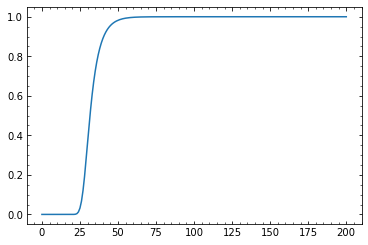

In [16]:
plt.plot(probs);

From the cumulative probability distribution we can easily extract the quantities we discussed above from the simulation.  Since the cumulative probability distribution is already ordered, it is easy to extract the required information using NumPy functions.  Here I will use the `where` function, but there are other ways.

In [17]:
print(f"""
Minimum rolls : {np.where(probs>0)[0][0]}
Median rolls  : {np.where(probs>=0.5)[0][0]}
99% win rolls : {np.where(probs>=0.99)[0][0]}
""")


Minimum rolls : 17
Median rolls  : 32
99% win rolls : 54



Notice that now we *can* get the expected minimum number of rolls and that the median and 99% values agree with the realizations.  This was a far more efficient that doing realizations!

## Chutes and Ladders

This simple game is nice, but we started with Chutes and Ladders.  We can now use a similar procedure as developed above to study this game.  The only difference, as seen in the figure, is that some spots on the board are connected to others: if we land on certain spots we can "climb" up the ladder to further points, in others we "slide down" the chute to an earlier point.  In other words, all we need to do is map certain values on the board to other values.

In matrix language, this just means the transition matrix for Chutes and Ladders is related to the transition matrix from our simple game by matrix multiplication:
$$ \mathsf{P}_{\mathrm{CL}} = \mathsf{M}\mathsf{P}. $$

This *mapping matrix*, $\mathsf{M}$, can be constructed elegantly in Python using a dictionary.  The following function shows a clever way of doing this.

In [18]:
def chutes_ladder_mapping_matrix () :
    # A Python dictionary containing the mappings between the
    # start and end spaces for the chutes and ladders.
    CHUTES_LADDERS = {1:38, 4:14, 9:31, 16:6, 21:42, 28:84, 36:44,
                      47:26, 49:11, 51:67, 56:53, 62:19, 64:60,
                      71:91, 80:100, 87:24, 93:73, 95:75, 98:78}
    # Construct the matrix.  We will use a loop since it is easy.
    M = np.zeros((101, 101))
    for i in range(M.shape[0]) :
        # Making clever use of the dictionary .... 
        ind = CHUTES_LADDERS.get(i, i)
        M[ind, i] = 1
    return M

With this we can now construct the appropriate transition matrix for Chutes and Ladders and follow the procedure we developed above.

To begin, we construct this matrix and look at the one roll state.  In the mapping matrix we see that $1\rightarrow 38$ and $4\rightarrow 14$.  Thus the one roll state should *not* have any probability of ending in state $1$ or state $4$, instead those probabilities should be mapped to states $38$ and $14$, respectively.  We verify this below.

In [19]:
# Reuse the transition matrix function from above.
PCL = chutes_ladder_mapping_matrix() @ make_transition_matrix(100, 6)
q0 = np.zeros(PCL.shape[1])
q0[0] = 1
q1 = PCL @ q0
print("One roll state =", q1)
# Verify certain entries are as they should be
assert(np.allclose((q1[1], q1[4], q1[38], q1[14]),
                  (0, 0, 1/6, 1/6)))

One roll state = [0.         0.         0.16666667 0.16666667 0.         0.16666667
 0.16666667 0.         0.         0.         0.         0.
 0.         0.         0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.      

Again we look to see if the game always ends by calculating the eigenvalues and eigenvectors of the transition matrix.

In [20]:
(lam, B) = la.eig(PCL)
print("Eigenvalues =", lam)
# Stationary states are where the eigenvalue is one.
# By inspection this occurs for the first eigenvalue so we 
# hardcode that here.
print("Stationary state =", B[:,0])

Eigenvalues = [ 1.        +0.j          0.83333333+0.j          0.95974702+0.j
  0.39766699+0.65056398j  0.39766699-0.65056398j  0.75528992+0.j
  0.59962931+0.31949257j  0.59962931-0.31949257j  0.2395178 +0.58898355j
  0.2395178 -0.58898355j  0.48472834+0.27217982j  0.48472834-0.27217982j
  0.53989097+0.j         -0.07800856+0.50227124j -0.07800856-0.50227124j
 -0.23037169+0.39933494j -0.23037169-0.39933494j  0.33333333+0.j
 -0.20793284+0.3379648j  -0.20793284-0.3379648j   0.21690016+0.19936979j
  0.21690016-0.19936979j -0.00932293+0.23377452j -0.00932293-0.23377452j
  0.11811478+0.12257517j  0.11811478-0.12257517j  0.13271001+0.j
 -0.02569754+0.20490514j -0.02569754-0.20490514j -0.12410017+0.20148472j
 -0.12410017-0.20148472j -0.00494355+0.16286647j -0.00494355-0.16286647j
 -0.15251522+0.14378912j -0.15251522-0.14378912j -0.18865752+0.10079938j
 -0.18865752-0.10079938j -0.16455457+0.09460887j -0.16455457-0.09460887j
 -0.08736459+0.108426j   -0.08736459-0.108426j   -0.18139231+0.j
 -0.

Once again we see there is a single stationary state and that it consists of winning the game.

We can now again calculate the cumulative probability distribution for this game and calculate the same quantities as above.

In [21]:
probs_CL = np.zeros(201)
for n in range(len(probs_CL)) :
    probs_CL[n] = np.dot(np.linalg.matrix_power(PCL,n), q0)[-1]
print(f"""
Minimum rolls : {np.where(probs_CL>0)[0][0]}
Median rolls  : {np.where(probs_CL>=0.5)[0][0]}
99% win rolls : {np.where(probs_CL>=0.99)[0][0]}
""")


Minimum rolls : 7
Median rolls  : 32
99% win rolls : 128



Do these results make sense?  How should we think about them?

It seems resonable both that the minimum is smaller and the maximum is larger.  The short cuts (ladders) mean that under optimal conditions we can get to the end more quickly than in the simple game where we had no short cuts.  On the other hand, since we can fall back (chutes) it means we can also need to effectively roll a sum larger than 100 to get to the end, thus it can take longer.  I do not think I have a good argument about the median, ....

As a final comparison of the two, we can look at their cumulative probability distributions.

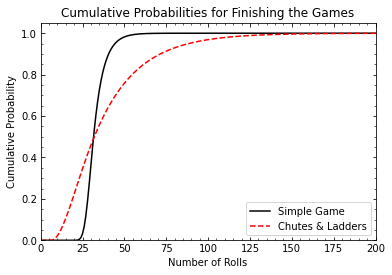

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(probs, 'k-', label='Simple Game')
ax.plot(probs_CL, 'r--', label='Chutes & Ladders')
ax.set_xlabel('Number of Rolls')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Cumulative Probabilities for Finishing the Games')
ax.legend(loc='best')
ax.set_xlim(0, len(probs)-1)
ax.set_ylim(bottom=0);

### Summary

Overall, we see that treating these games as Markov processes has greatly enhanced our ability to analyze them.  The techniques we have learned are far more efficient than a brute force, realization based approach.  There is much more we could do.  The blog post shows some other things we can study, including treating Chutes and Ladders as an absorbing Markov process.

One thing we did not do was generate realizations of Chutes and Ladders.  We could have easily done that by modifying `simulate_dice_game` to include the mapping matrix $\mathsf{M}$.  If we had done so, would we have found the minimum number of rolls required? Additionally, how many realizations would we need to win a game with the minimum number of rolls?

We can quantify this using the Markov process analysis, the cumulative probability distribution provides the answers.

In [23]:
print(f"""
Minimum number of rolls probabilities:
Simple Game      : {probs[17]}
Chutes & Ladders : {probs_CL[7]}
                   or once every {int(1/probs_CL[7]+0.5)} games
""")


Minimum number of rolls probabilities:
Simple Game      : 9.038995585604531e-12
Chutes & Ladders : 0.0015110596707818928
                   or once every 662 games



So we see that about once in 700 games of Chutes of Ladders we would expect to win with the minimum number of rolls.  On the other hand, for the simple game we would only win with the minimum number of rolls once in $10^{11}$ games!  We do not want to do enough realizations of the simple game to get a statistically trustworthy estimate for the minimum number of rolls!  The Markov process analysis was essential for getting meaninful results for that game.

To see this more clearly, for the probability of winning after $n$ rolls denoted by $p_n$, an estimate of the number of games we would need to play to win after $n$ rolls is $1/p_n$.  These values are given below.

In [24]:
print(f"""Number of games played to win
17 rolls : {1/probs[17]:.1e} games
18 rolls : {1/probs[18]:.1e} games
19 rolls : {1/probs[19]:.1e} games
20 rolls : {1/probs[20]:.1e} games
21 rolls : {1/probs[21]:.1e} games
""")

Number of games played to win
17 rolls : 1.1e+11 games
18 rolls : 9.4e+07 games
19 rolls : 1.4e+06 games
20 rolls : 6.5e+04 games
21 rolls : 6.5e+03 games



Thus we would might find a minimum of 20 rolls from our set of realizations and almost certainly at least 21 rolls.

The important feature of these games is that the next step in the game does not depend on the previous step.  This is not true of some other games, such as Candy Land.  Perhaps there are modifications to the strict Markov process that we have used here that would appropriate for them.